In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

In [ ]:
train_df['year'] = train_df['datetime'].apply(lambda x: x.year)
train_df['month'] = train_df['datetime'].apply(lambda x: x.month)
train_df['day'] = train_df['datetime'].apply(lambda x: x.day)
train_df['hour'] = train_df['datetime'].apply(lambda x: x.hour)

test_df['year'] = test_df['datetime'].apply(lambda x: x.year)
test_df['month'] = test_df['datetime'].apply(lambda x: x.month)
test_df['day'] = test_df['datetime'].apply(lambda x: x.day)
test_df['hour'] = test_df['datetime'].apply(lambda x: x.hour)

In [ ]:
train_df = train_df.drop(['datetime', 'casual', 'registered'], axis=1)
test_df = test_df.drop(['datetime'], axis=1)

In [ ]:
from collections import Counter 

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(train, 2, ["temp", "atemp", "humidity", "windspeed","registered", "casual","count"])

In [ ]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


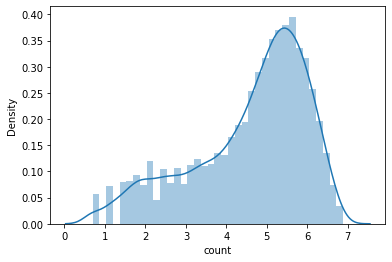

In [ ]:
sns.distplot(np.log1p(train_df['count']))

In [ ]:
train_df['count'] = np.log1p(train_df['count'])

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['count'], axis=1), train_df['count'], test_size=0.3)

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('RMSLE:', rmsle(y_test_exp, pred_exp))

RMSLE: 1.012747014102974


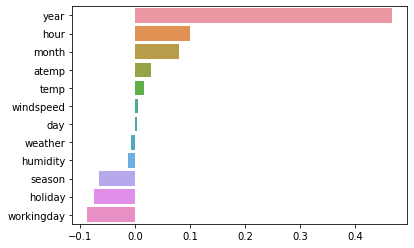

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [ ]:
train_df = pd.get_dummies(train_df, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])
test_df = pd.get_dummies(test_df, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [ ]:
train_df, test_df = train_df.align(test_df, join='left', axis=1)
test_df = test_df.drop(['count'], axis=1)

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['count'], axis=1), train_df['count'], test_size=0.3)

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('LinearRegression RMSLE:', rmsle(y_test_exp, pred_exp))

LinearRegression RMSLE: inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in expm1
  


In [ ]:
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
pred = ridge_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('Ridge RMSLE:', rmsle(y_test_exp, pred_exp))

Ridge RMSLE: 0.5844481961712159


In [ ]:
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train, y_train)
pred = lasso_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('Lasso RMSLE:', rmsle(y_test_exp, pred_exp))

Lasso RMSLE: 0.643241027577229


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('RandomForestRegressor RMSLE:', rmsle(y_test_exp, pred_exp))

RandomForestRegressor RMSLE: 0.3531622723557044


In [ ]:
gbm_reg = GradientBoostingRegressor(n_estimators=500)
gbm_reg.fit(X_train, y_train)
pred = gbm_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('GradientBoostingRegressor RMSLE:', rmsle(y_test_exp, pred_exp))

GradientBoostingRegressor RMSLE: 0.3425101664910409
